# Manually setting up a RNN

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#Constants
num_inputs = 2
num_neurons = 3

#placeholders for the timestamps (it would be ridiculous to do it in a regular RNN)
x0 = tf.placeholder(tf.float32,(None,num_inputs))
x1 = tf.placeholder(tf.float32,(None,num_inputs))

#variables
Wx = tf.Variable(tf.random_normal(shape = (num_inputs,num_neurons)))
Wy = tf.Variable(tf.random_normal(shape = (num_neurons,num_neurons)))
b = tf.Variable(tf.zeros(shape = (1,num_neurons)))

#Graph
y0 = tf.tanh(tf.matmul(x0,Wx)+b)
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1,Wx) + b)
init = tf.global_variables_initializer()

In [14]:
#Creating DATA
#Time Stamp 0
x0_batch = np.array([[0,1],[2,3],[4,5]])
#timestamp 1
x1_batch = np.array([[100,101],[102,103],[104,105]])

In [15]:
with tf.Session() as sess:
    sess.run(init)
    y0_output_vals, y1_output_vals = sess.run([y0,y1],feed_dict={x0:x0_batch,x1:x1_batch})

In [17]:
y0_output_vals

array([[ 0.14385472, -0.7283546 , -0.79494447],
       [-0.907924  , -0.99979883, -0.9985661 ],
       [-0.99651957, -0.99999976, -0.99999106]], dtype=float32)

In [1]:
y1_output_vals

NameError: name 'y1_output_vals' is not defined

# RNN with Tensorflow

In [3]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.ytrue = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        #Grab a random starting point for the batch
        rand_start = np.random.rand(batch_size,1)
        
        #Convert to be on a time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        #create a batch time series on the x axis
        batch_ts = ts_start+np.arange(0.0,steps+1)*self.resolution
        
        #create the y data for the time series x axis from the previous data
        y_batch = np.sin(batch_ts)
        
        #FORMATTING for the RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [4]:
ts_data = TimeSeriesData(250,0,10)

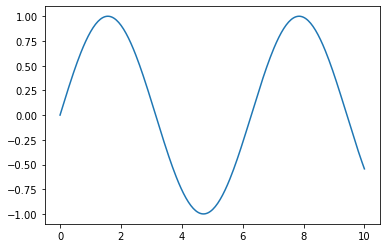

In [7]:
plt.plot(ts_data.x_data,ts_data.ytrue)

In [8]:
num_time_steps = 30

In [9]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

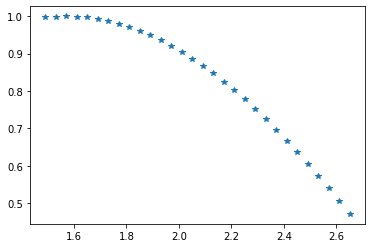

In [10]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

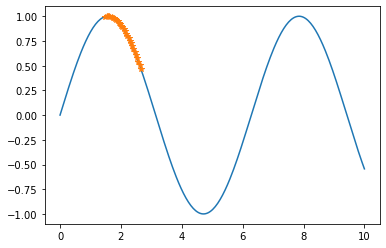

In [12]:
plt.plot(ts_data.x_data,ts_data.ytrue)
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

In [13]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

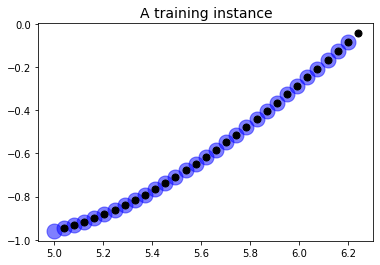

In [14]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

# Create Model

In [15]:
tf.reset_default_graph()

In [16]:
num_inputs = 1

In [17]:
num_neurons = 100

In [18]:
num_outputs = 1

In [19]:
learning_rate = 0.0001

In [20]:
num_train_interations = 2000

In [21]:
batch_size = 1

In [22]:
#Placeholders

X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

## Create RNN cell layer

In [24]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu),
    output_size=num_outputs)

In [26]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [29]:
init = tf.global_variables_initializer()

## Session

In [30]:
saver = tf.train.Saver()

In [31]:
with tf.Session() as sess:
    sess.run(init)
    
    for interation in range(num_train_interations):
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        
        if interation%100==0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(interation,"\tMSE",mse)
            
        saver.save(sess,"./rnn_time_series_model_codealong")

0 	MSE 0.69110227
100 	MSE 0.19331035
200 	MSE 0.08123442
300 	MSE 0.05774149
400 	MSE 0.0064076986
500 	MSE 0.030585567
600 	MSE 0.009395689
700 	MSE 0.0297034
800 	MSE 0.0001799915
900 	MSE 0.01415888
1000 	MSE 0.017879615
1100 	MSE 0.007376973
1200 	MSE 0.005846888
1300 	MSE 0.002783724
1400 	MSE 0.014849126
1500 	MSE 0.0014626037
1600 	MSE 9.175212e-05
1700 	MSE 0.013029625
1800 	MSE 0.0010344025
1900 	MSE 0.004790151


In [32]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_codealong")
    
    X_new = np.sin(np.array(train_inst[:-1]).reshape(-1,num_time_steps,num_inputs))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


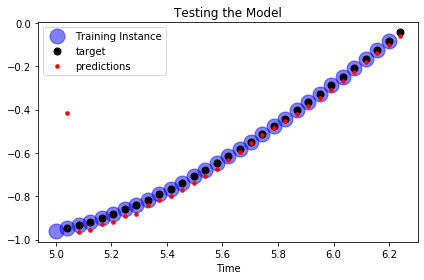

In [35]:
plt.title("Testing the Model")

plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="Training Instance")
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=7,label="target")
plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=7,label="predictions")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating a New Sequence

In [51]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_codealong")
    
    #SEED ZEROS
    
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for interations in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(-1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0, 0.5, 'Value')

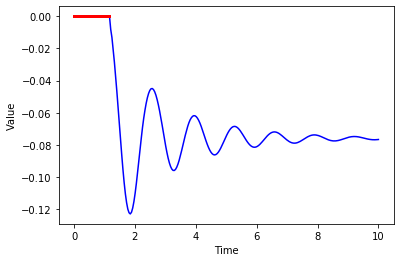

In [52]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [55]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_codealong")
    
  
    
    training_instance = list(ts_data.ytrue[:30])
    for interations in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(-1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0.5, 0, 'Time')

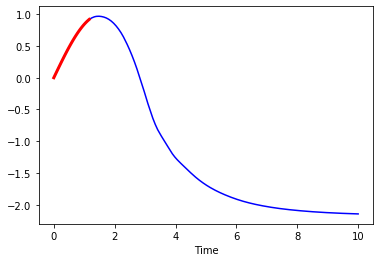

In [56]:
plt.plot(ts_data.x_data, training_instance , "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")